### Imports

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sym

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Some notes

The YIG operates like a hot bath, so the number of photons should be similar to the number of photons from the thermal bath $n_T$.

To solve for the number of photons in the cavity mode, we can use a delightful formula (see Kurt's notes for the citation).  If the integral has the form $I_n = \int_{-\infty}^{\infty}\frac{y_n(\nu)}{z_n(\nu)z_n(-\nu)}d\nu$, where $z_n{-\nu} = z_n(\nu)^*$, $y_n(\nu) = b_0\nu^{2n-2} + b_1\nu^{2n-4} + ... + b_{n-1}$, and $z_n(\nu) = a_0\nu^n + a_1\nu^{n-1} + ... + a_n$, then

$I_n = \frac{\pi}{a_0}\left|\frac{M_n}{L_n} \right|$, where $M_n = 
    \begin{vmatrix}
       b_0 & b_1 & b_2 & ... & b_{n-1} \\
       a_0 & a_2 & a_4 & ... & a_0 \\
       0 & a_1 & a_3 & ... & 0 \\
       \vdots & \vdots & \vdots & ... & \vdots \\
       0 & 0 & 0 & ... & a_n
    \end{vmatrix}$  and $L_n =
    \begin{vmatrix}
        a_1 & a_3 & a_5 & ... & 0 \\
       a_0 & a_2 & a_4 & ... & a_0 \\
       0 & a_1 & a_3 & ... & 0 \\
       \vdots & \vdots & \vdots & ... & \vdots \\
       0 & 0 & 0 & ... & a_n
    \end{vmatrix}$

So the idea is that we calculate what $S_A(\omega)$ is analytically, then input the terms into the matrices M and L and solve numerically for the average number of photons in the cavity mode.

When using the functions to get the a and b terms, note that they will not give you the expected results if you set the YIG terms to 0.  This is because they still create the 3x3 matrix and calculate the determinants with all of those zeros.  I haven't yet figured out how to take care of that with 1 function.

### Functions

In [3]:
def temp_from_photons(ω, num_photons):
    """
    function for calculating the temperature given the number of photons
    :param ω:           the frequency of the photons
    :param num_photons: the number of photons
    :returns:           the temperature
    """
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω, temp):
    """
    function for calculating the number of photons from a thermal bath
    :param ω:           the frequency of the photons
    :param temp:        the temperature of the bath
    :returns:           the number of photons
    """
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω / temp) - 1) ** -1

In [5]:
def get_a_list(κ, γ, r, χ, g, gy):
    """
    function for calculating the a terms for the integral formula above
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the damping rate of the NV ensemble
    :param χ:  the damping rate of the YIG
    :param g:  the cooperativity of the cavity and the NV ensemble
    :param gy: the cooperativivity of the cavity and the YIG
    :returns:  list of the a coefficients
    """
    a0 = 1j
    a1 = 0.5 * (κ + γ + r + χ)
    a2 = 0.25j * ((κ + γ)*r + (κ + γ)*χ + r*χ + 4*g**2 + 4*gy**2)
    a3 = -0.5 * ((κ + γ)*r*χ / 4 + χ*g**2 + r*gy**2)

    return np.array([a0, a1, a2, a3])

In [6]:
def get_b_list(κ, γ, r, χ, g, gy, nc, ny, nT):
    """
    function for calculating the a terms for the integral formula above
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the damping rate of the NV ensemble
    :param χ:  the damping rate of the YIG
    :param g:  the cooperativity of the cavity and the NV ensemble
    :param gy: the cooperativivity of the cavity and the YIG
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param ny: the number of photons in the YIG mode
    :param nT: the number of photons in the thermal bath
    :returns:  list of the b coefficients
    """
    b0 = (κ + γ)*nT
    b1 = 0.25 * (r**2 + χ**2) * (κ + γ)*nT + r*nc*g**2 + χ*ny*gy**2
    b2 = 0.25 * (r**2*χ**2 / 4 * (κ + γ) * nT + g**2 * χ**2 * r * nc + gy**2 * r**2 * χ * ny)

    return np.array([b0, b1, b2])

In [7]:
def m_det(b_list, a_list):
    """
    function for calculating the determinant of the M matrix in the integral formula above
    :param b_list: the list of the b coefficients
    :param a_list: the list of the a coefficients
    :returns:      the determinant of M
    """
    # First construct the matrix
    M = np.zeros((b_list.size, b_list.size), dtype=complex)

    # Now fill in with the appropriate values
    M[0, :] = b_list.copy()
    M[1, 0] = a_list[0]
    M[1, 1] = a_list[2]
    M[2, 1] = a_list[1]
    M[2, 2] = a_list[3]

    # Return the determinant
    return linalg.det(M)

In [8]:
def l_det(a_list):
    """
    function for calculating the determinant of the L matrix in the integral formula above
    :param a_list: the list of the a coefficients
    :returns:      the determinant of L
    """
    # First construct the matrix
    L = np.zeros((a_list.size-1, a_list.size-1), dtype=complex)

    # Now fill in with the appropriate values
    L[0, 0] = a_list[1]
    L[0, 1] = a_list[3]
    L[1, 0] = a_list[0]
    L[1, 1] = a_list[2]
    L[2, 1] = a_list[1]
    L[2, 2] = a_list[3]

    # Return the determinant
    return linalg.det(L)

In [9]:
def nv_mean_photons(κ, γ, g, r, nT, nc):
    """
    function for calculating the steady state photon number in the cavity per equation 98 in Kurt's supplemental info document
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :returns:  the average number of photons in the cavity mode
    """
    num = (κ + γ) * nT + r * g ** 2 / ((r / 2)**2 + (r / 2)*((κ + γ) / 2) + g ** 2) * nc
    den = (κ + γ) + r * g ** 2 / ((r / 2)**2 + (r / 2)*((κ + γ) / 2) + g ** 2)
    return num / den

In [10]:
def full_output_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, Ω):
    """
    function for calculating the full output spectrum of the cavity including the YIG and NV ensemble
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param gy: the cooperativity of the YIG and the cavity
    :param χ:  the damping rate of the YIG
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param ny: the number of photons in the YIG
    :param Δ:  the cavity-spin detuning
    :param Ω:  the cavity-YIG detuning
    :returns:  the output spectrum
    """
    # Define M collect coupling rates together
    M = κ + γ

    # Numerator will be a + b + c, denominator will be d + e + f
    a = (r ** 2 / 4 + ω ** 2) * (χ ** 2 / 4 + (ω - Ω) ** 2) * κ * γ * nT
    b = g ** 2 * (χ ** 2 / 4 + (ω - Ω) ** 2) * nc * κ * r # Double check if this should have κ r
    c = gy ** 2 * (r ** 2 / 4 + ω ** 2) * ny * κ * χ # Double check if this should have κ χ
    a2 = ((κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) * (χ / 2 - 1j * (ω - Ω))
    b2 = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    c2 = gy ** 2 * (r / 2 - 1j * ω)
    num = a + b + c + nT * np.abs(a2 - b2 - c2) ** 2

    d = ((κ + γ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j*ω) * (χ / 2 - 1j * (ω - Ω))
    e = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    f = gy ** 2 * (r / 2 - 1j*ω)
    den = np.abs(d + e + f) ** 2

    return num / den

In [11]:
def nv_output_spec(ω, g, r, κ, γ, nT, nc, Δ):
    """
    function for calculating the full output spectrum of the cavity with just the NV ensemble.  Note: this is mostly for testing purposes
    as the full output spectrum function should yield the same thing when the YIG terms are 0
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param Δ:  the cavity-spin detuning
    :returns:  the output spectrum
    """
    num = κ * r * g ** 2 * (nc - nT)
    d = (r ** 2 / 4 + ω ** 2) * ((κ + γ) ** 2 /4 + (ω - Δ) ** 2)
    e = g ** 2 * (r * (κ + γ) / 2 - 2 * ω * (ω - Δ))
    f = g ** 4
    den = d + e + f
    #print("num: ", num)
    #print("d: ", d)
    #print("e: ", e)
    #print("f: ", f)
    #print("den: ", den)

    return nT + num / den

In [12]:
def full_cavity_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, Ω):
    """
    function for calculating the cavity spectrum with the YIG and NV ensemble
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param gy: the cooperativity of the YIG and the cavity
    :param χ:  the damping rate of the YIG
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param ny: the number of photons in the YIG
    :param Δ:  the cavity-spin detuning
    :param Ω:  the cavity-YIG detuning
    :returns:  the output spectrum
    """
    a = (r ** 2 / 4 + ω ** 2) * (χ ** 2 / 4 + (ω - Ω) ** 2) * (κ + γ) * nT
    b = g ** 2 * r * (χ ** 2 / 4 + (ω - Ω) ** 2) * nc
    c = gy ** 2 * χ * (r ** 2 / 4 + ω ** 2) * ny
    num = a + b + c

    d = ((κ + γ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) * (χ / 2 - 1j * (ω - Ω))
    e = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    f = gy ** 2 * (r /2 - 1j * ω)
    den = np.abs(d + e + f) ** 2

    return num / den

In [13]:
def nv_cavity_spec(ω, g, r, κ, γ, nT, nc, Δ):
    """
    function for calculating the cavity spectrum with just the NV ensemble.  Note: this is mostly for testing purposes
    as the full output spectrum function should yield the same thing when the YIG terms are 0
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param Δ:  the cavity-spin detuning
    :returns:  the output spectrum
    """
    a = (r ** 2 / 4 + ω ** 2) * (κ + γ) * nT
    b = g ** 2 * r * nc
    num = a + b

    d = (r / 2 - 1j * ω) * ((κ + γ) / 2 - 1j * (ω - Δ))
    den = np.abs(d + g ** 2) ** 2

    return num / den

In [14]:
def get_polariton_freq(κ, γ, Δ, g, r, Ω, gy, χ):
    """
    function for calculating the polariton frequencies given a set of experimental parameters
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the NV ensemble and the cavity mode
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param Ω:  the detuning between the YIG and the cavity
    :param gy: the cooperativity between the YIG and the cavity
    :param χ:  the damping rate of the YIG
    :return:   the polariton frequencies obtained by calculating the eigenvalues of the matrix in Eq. 68 in my notes
    """
    # Define the matrix
    M = np.zeros((3, 3), dtype=complex)
    temp = [
         [(κ + γ) / 2 + 1j*Δ, 1j * g, -1j * gy],
         [1j * g, r / 2, 0],
         [-1j * gy, 0, χ / 2 + 1j*Ω]
        ]
    
    #for i in range(len(temp)):
    #    for j in range(len(temp[i])):
    #        M[i][j] = temp[i][j]

    # Calculate the eigenvalues
    eig = linalg.eigvals(np.array(temp))

    # return
    return np.sort(eig.imag)

In [15]:
def get_nv_polariton_freq(κ, γ, Δ, g, r):
    """
    function for calculating the polariton frequencies given a set of experimental parameters
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the NV ensemble and the cavity mode
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :return:   the eigenvalues
    """
    M = [
        [(κ + γ) / 2 + 1j*Δ, 1j * g],
        [1j * g, r / 2]
    ]
    M = np.array(M)

    return np.sort(linalg.eigvals(M).imag)

### Test
The results including the YIG should reduce to the results of the NV-cavity setup when the YIG terms are set to 0.  This is a useful check that our code is functioning as expected.  We'll first check the average number of photons in the cavity mode, then we'll check the output spectrum.

In [16]:
# First define the parameters we'll need
ωc = 2 * np.pi * 2.87e9  # Hz
κ = 1
T = 5
Q = 2.5e4
γ = ωc / Q
g = 1e7 # Hz
r = g
P = 1
nc = 0.5 * (1 - P) / P
nT = photons_from_temp(ωc, T)

In [17]:
expected_nbar = nv_mean_photons(κ, γ, g, r, nT, nc)

In [18]:
# Now, we can't actually just use the functions above to generate the results without the YIG.  This is because the size of the matrices
# get messed up.  So we have to do it manually
# With the YIG off, we have n=2 for M_n and L_n.  That means we need a0, a1, a2 and b0, b1.
a0 = 1
a1 = 1j*(r + κ + γ) / 2
a2 = -(κ + γ) * r / 4 - g ** 2
b0 = (κ + γ) * nT
b1 = (κ + γ) * nT / 4 * r ** 2 + r * nc + g ** 2

M2 = np.array([[b0, b1], [a0, a2]])
M2_det = linalg.det(M2)
L2 = np.array([[a1, 0], [a0, a2]])
L2_det = linalg.det(L2)
    
no_yig_nbar = 1 / (2 *np.abs(a0)) * np.abs(M2_det / L2_det)

In [19]:
print("Expected $\\bar{n}$: ", expected_nbar)
print("Calculated $\\bar{n}$: ", no_yig_nbar)

Expected $\bar{n}$:  2.9999823055234396
Calculated $\bar{n}$:  2.999982397143455


In [20]:
g = np.logspace(6, 8, 1000)
r = g.copy()
expected_nbar = nv_mean_photons(κ, γ, g, r, nT, nc)

In [21]:
no_yig_nbar = np.zeros(g.shape[0], dtype=complex)
for i in range(g.shape[0]):
    temp_a0 = 1
    temp_a1 = 1j*(r[i] + κ + γ) / 2
    temp_a2 = -(κ + γ) * r[i] / 4 - g[i] ** 2
    temp_b0 = (κ + γ) * nT
    temp_b1 = (κ + γ) * nT / 4 * r[i] ** 2 + r[i] * nc + g[i] ** 2

    temp_M2 = np.array([[temp_b0, temp_b1], [temp_a0, temp_a2]])
    temp_M2_det = linalg.det(temp_M2)
    temp_L2 = np.array([[temp_a1, 0], [temp_a0, temp_a2]])
    temp_L2_det = linalg.det(temp_L2)

    no_yig_nbar[i] = 1 / (2 *np.abs(temp_a0)) * np.abs(temp_M2_det / temp_L2_det)

/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


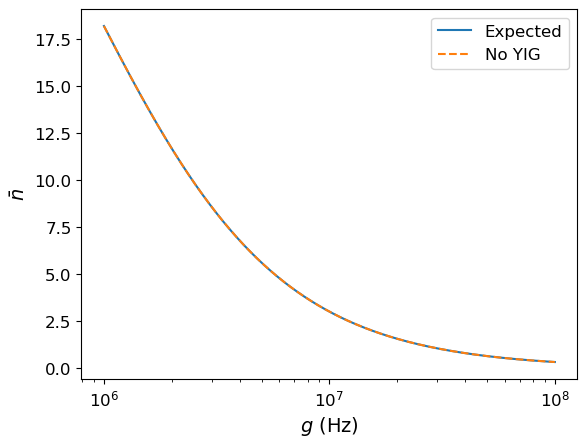

In [22]:
plt.semilogx(g, expected_nbar, label='Expected')
plt.semilogx(g, no_yig_nbar, '--', label='No YIG')
plt.xlabel("$g$ (Hz)")
plt.ylabel("$\\bar{n}$")
plt.legend()

In [23]:
polariton_freq_a = np.zeros(g.shape[0], dtype=complex)
polariton_freq_b = np.zeros(g.shape[0], dtype=complex)
for i in range(g.shape[0]):
    temp = get_nv_polariton_freq(κ, γ, 0, g[i], g[i])
    polariton_freq_a[i] = temp[0]
    polariton_freq_b[i] = temp[1]

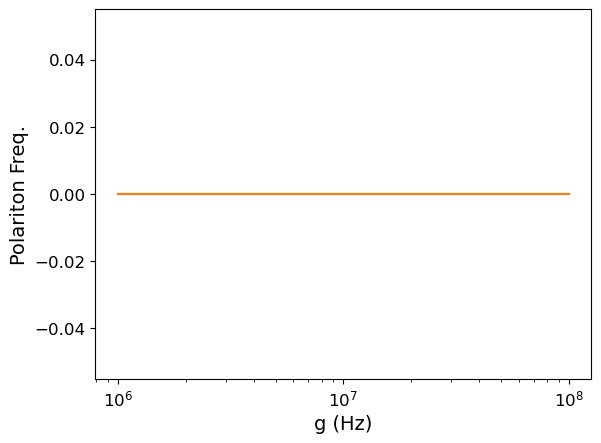

In [24]:
plt.plot(g, polariton_freq_a.imag)
plt.plot(g, polariton_freq_b.imag)
plt.xlabel("g (Hz)")
plt.ylabel("Polariton Freq.")
plt.xscale('log')

In [25]:
# Now we want to compare the output spectra
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
g = 2 * np.pi * 197.7e3
P = 0.8
nc = 0.5 * (1 - P) / P
ω = 2 * np.pi * np.linspace(-1.5, 1.5, 1000) * 1e6 # Hz
Δ = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6 # Hz
ωm, Δm = np.meshgrid(ω, Δ)
expected_spectra_a = nv_output_spec(ωm, g, r, κ, γ, nT, nc, Δm - 2.15 * 2 * np.pi * 1e6)
expected_spectra_b = nv_output_spec(ωm, g, r, κ, γ, nT, nc, Δm - 0)
expected_spectra_c = nv_output_spec(ωm, g, r, κ, γ, nT, nc, Δm + 2.15 * 2 * np.pi * 1e6)
expected_spectra = 0.33 * expected_spectra_a + 0.33 * expected_spectra_b + 0.33 * expected_spectra_c

In [26]:
calculated_spectra_a = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm - 2.15 * 2 * np.pi * 1e6, 0)
calculated_spectra_b = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm - 0, 0)
calculated_spectra_c = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm + 2.15 * 2 * np.pi * 1e6, 0)
calculated_spectra = 0.33 * calculated_spectra_a + 0.33 * calculated_spectra_b + 0.33 * calculated_spectra_c

In [27]:
# Calculate polariton frequencies - I'm assuming here that Δ is 0
polariton_freqs_a, polariton_freqs_b = get_nv_polariton_freq(κ, γ, 0, g, r)
print(polariton_freqs_a, polariton_freqs_b)

-1232979.4943518604 1232979.4943518601


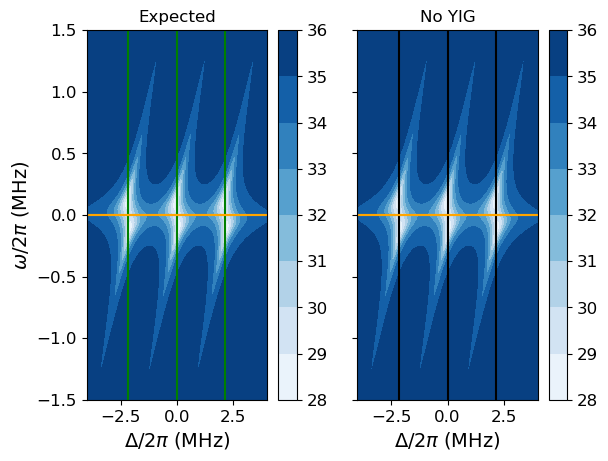

In [28]:
fig1 = plt.figure(1)
ax = fig1.subplots(1, 2, sharex='all', sharey='all')
im1 = ax[0].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), expected_spectra, cmap='Blues')
ax[0].axvline(x=-2.15, color='g')
ax[0].axvline(x=0, color='g')
ax[0].axvline(x=2.15, color='g')
ax[0].axhline(y=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[0].axhline(y=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[0].set_xlabel("$\\Delta / 2\\pi$ (MHz)")
ax[0].set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_title("Expected")

im2 = ax[1].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), calculated_spectra, cmap='Blues')
ax[1].axvline(x=-2.15, color='k')
ax[1].axvline(x=0, color='k')
ax[1].axvline(x=2.15, color='k')
ax[1].axhline(y=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[1].axhline(y=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[1].set_xlabel("$\\Delta / 2\\pi$ (MHz)")
ax[1].set_title("No YIG")
fig1.colorbar(im1)
fig1.colorbar(im2)

Text(0.5, 0, '$\\omega / 2\\pi$ (MHz)')

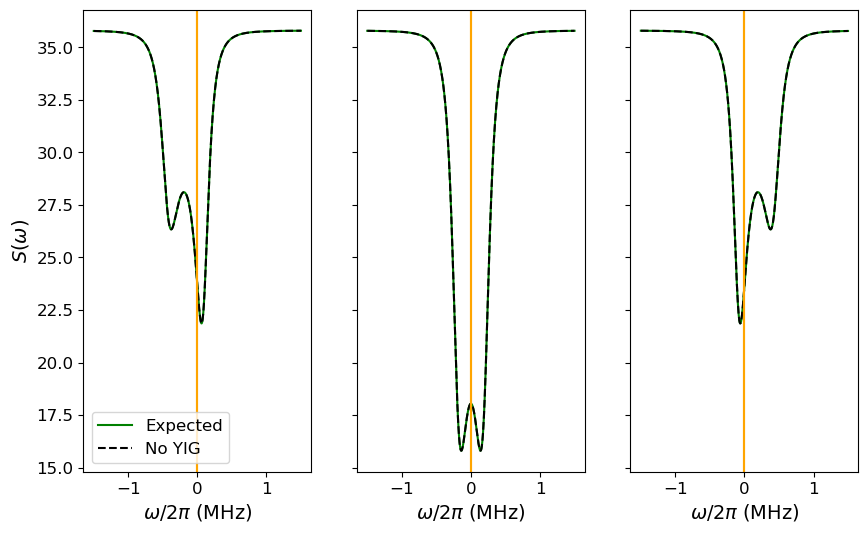

In [29]:
exp_l = nv_output_spec(ω, g, r, κ, γ, nT, nc, -2.15 * 1e6)
exp_m = nv_output_spec(ω, g, r, κ, γ, nT, nc, 0)
exp_r = nv_output_spec(ω, g, r, κ, γ, nT, nc, 2.15 * 1e6)

calc_l = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, - 2.15  * 1e6, 0)
calc_m = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, 0, 0)
calc_r = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, 2.15 * 1e6, 0)

fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
ax[0].plot(ω / (2 * np.pi * 1e6), exp_l, 'g-', label='Expected')
ax[0].plot(ω / (2 * np.pi * 1e6), calc_l, 'k--', label='No YIG')
ax[0].axvline(x=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[0].axvline(x=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[0].set_xlabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_ylabel("$S(\\omega)$")
ax[0].legend()

ax[1].plot(ω / (2 * np.pi * 1e6), exp_m, 'g-')
ax[1].plot(ω / (2 * np.pi * 1e6), calc_m, 'k--')
ax[1].axvline(x=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[1].axvline(x=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[1].set_xlabel("$\\omega / 2\\pi$ (MHz)")

ax[2].plot(ω / (2 * np.pi * 1e6), exp_r, 'g-')
ax[2].plot(ω / (2 * np.pi * 1e6), calc_r, 'k--')
ax[2].axvline(x=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[2].axvline(x=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[2].set_xlabel("$\\omega / 2\\pi$ (MHz)")

In [30]:
# Now let's compare cavity spectra
# Now we want to compare the output spectra
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
g = 2 * np.pi * 197.7e3
P = 0.8
nc = 0.5 * (1 - P) / P
ω = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6 # Hz
Δ = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6 # Hz
ωm, Δm = np.meshgrid(ω, Δ)
expected_spectra_a = nv_cavity_spec(ωm, g, r, κ, γ, nT, nc, Δm - 2.15 * 2 * np.pi * 1e6)
expected_spectra_b = nv_cavity_spec(ωm, g, r, κ, γ, nT, nc, Δm - 0)
expected_spectra_c = nv_cavity_spec(ωm, g, r, κ, γ, nT, nc, Δm + 2.15 * 2 * np.pi * 1e6)
expected_spectra = 0.33 * expected_spectra_a + 0.33 * expected_spectra_b + 0.33 * expected_spectra_c

In [31]:
calculated_spectra_a = full_cavity_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm - 2.15 * 2 * np.pi * 1e6, 0)
calculated_spectra_b = full_cavity_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm - 0, 0)
calculated_spectra_c = full_cavity_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm + 2.15 * 2 * np.pi * 1e6, 0)
calculated_spectra = 0.33 * calculated_spectra_a + 0.33 * calculated_spectra_b + 0.33 * calculated_spectra_c

In [32]:
# Calculate polariton frequencies - I'm assuming here that Δ is 0
polariton_freqs_a, polariton_freqs_b = get_nv_polariton_freq(κ, γ, 0, g, r)
print(polariton_freqs_a, polariton_freqs_b)

-1232979.4943518604 1232979.4943518601


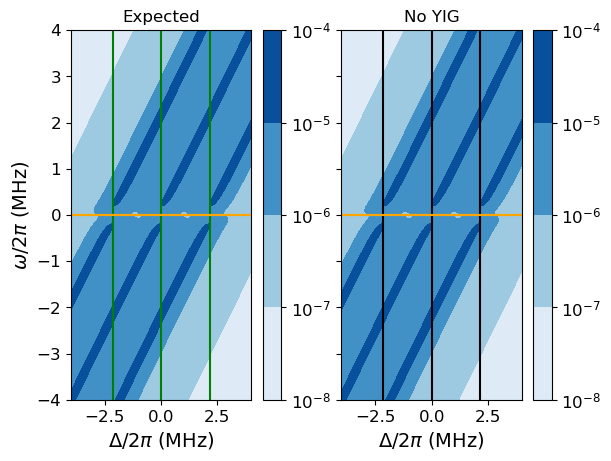

In [33]:
fig1 = plt.figure(1)
ax = fig1.subplots(1, 2, sharex='all', sharey='all')
im1 = ax[0].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), expected_spectra, cmap='Blues', norm=mpl.colors.LogNorm())
ax[0].axvline(x=-2.15, color='g')
ax[0].axvline(x=0, color='g')
ax[0].axvline(x=2.15, color='g')
ax[0].axhline(y=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[0].axhline(y=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[0].set_xlabel("$\\Delta / 2\\pi$ (MHz)")
ax[0].set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_title("Expected")

im2 = ax[1].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), calculated_spectra, cmap='Blues', norm=mpl.colors.LogNorm())
ax[1].axvline(x=-2.15, color='k')
ax[1].axvline(x=0, color='k')
ax[1].axvline(x=2.15, color='k')
ax[1].axhline(y=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[1].axhline(y=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[1].set_xlabel("$\\Delta / 2\\pi$ (MHz)")
ax[1].set_title("No YIG")
fig1.colorbar(im1)
fig1.colorbar(im2)

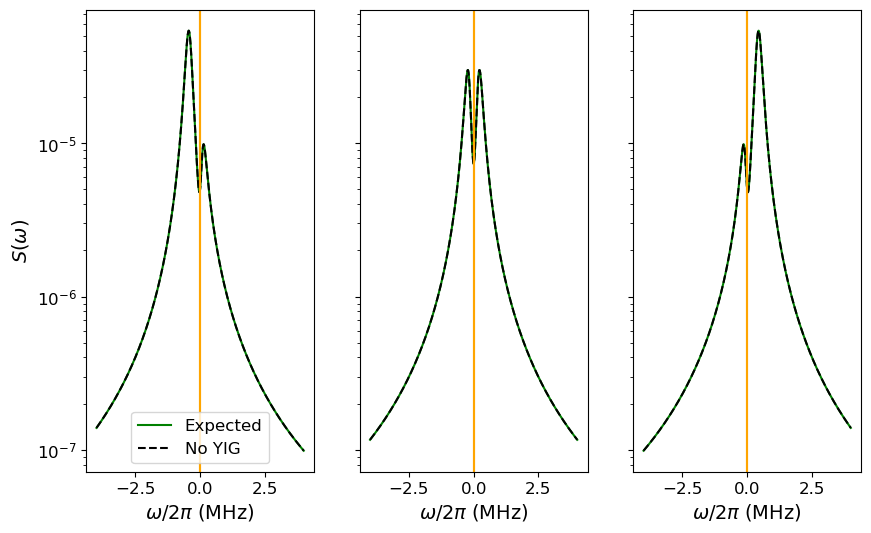

In [34]:
exp_l = nv_cavity_spec(ω, g, r, κ, γ, nT, nc, -2.15 * 1e6)
exp_m = nv_cavity_spec(ω, g, r, κ, γ, nT, nc, 0)
exp_r = nv_cavity_spec(ω, g, r, κ, γ, nT, nc, 2.15 * 1e6)

calc_l = full_cavity_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, - 2.15 * 1e6, 0)
calc_m = full_cavity_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, 0, 0)
calc_r = full_cavity_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, 2.15 * 1e6, 0)

fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
ax[0].plot(ω / (2 * np.pi * 1e6), exp_l, 'g-', label='Expected')
ax[0].plot(ω / (2 * np.pi * 1e6), calc_l, 'k--', label='No YIG')
ax[0].axvline(x=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[0].axvline(x=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[0].set_xlabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_ylabel("$S(\\omega)$")
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(ω / (2 * np.pi * 1e6), exp_m, 'g-')
ax[1].plot(ω / (2 * np.pi * 1e6), calc_m, 'k--')
ax[1].axvline(x=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[1].axvline(x=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[1].set_xlabel("$\\omega / 2\\pi$ (MHz)")
ax[1].set_yscale('log')

ax[2].plot(ω / (2 * np.pi * 1e6), exp_r, 'g-')
ax[2].plot(ω / (2 * np.pi * 1e6), calc_r, 'k--')
ax[2].axvline(x=polariton_freqs_a.imag / (2 * np.pi * 1e6), color='orange')
ax[2].axvline(x=polariton_freqs_b.imag / (2 * np.pi * 1e6), color='orange')
ax[2].set_xlabel("$\\omega / 2\\pi$ (MHz)")
ax[2].set_yscale('log')

### YIG Simulations

We'll start by doing parameter sweeps one at a time starting with $g_y$.

In [35]:
# First redefine parameters
ωc = 2 * np.pi * 2.87e9  # Hz
κ = 1e5
T = 5
Q = 2.5e4
γ = ωc / Q
P = 0.7
nc = 0.5 * (1 - P) / P
g = 1e7
r = g
nT = photons_from_temp(ωc, T)
print(γ)

721309.6732642165


#### $g_y$ sweep

In [36]:
# For now assume Δ = Ω = 0
Δ = 0
Ω = 0
ny = nT

gy = np.logspace(5, 8, 1000)
ω = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6

In [37]:
# No YIG spectrum
out_spec_no_yig = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, Δ, Ω)

# Set up meshgrid
gym, ωm = np.meshgrid(gy, ω)

# YIG spectrum sweep over gy
out_spec_gy_sweep = full_output_spec(ωm, g, r, gym, gym, κ, γ, nT, nc, ny, Δ, Ω)

In [38]:
polariton_freqs_a = np.zeros(gy.shape[0], dtype=complex)
polariton_freqs_b = np.zeros(gy.shape[0], dtype=complex)
polariton_freqs_c = np.zeros(gy.shape[0], dtype=complex)
for i in range(gy.shape[0]):
    temp = get_polariton_freq(κ, γ, 0, g, r, 0, gy[i], gy[i])
    polariton_freqs_a[i] = temp[0]
    polariton_freqs_b[i] = temp[1]
    polariton_freqs_c[i] = temp[2]


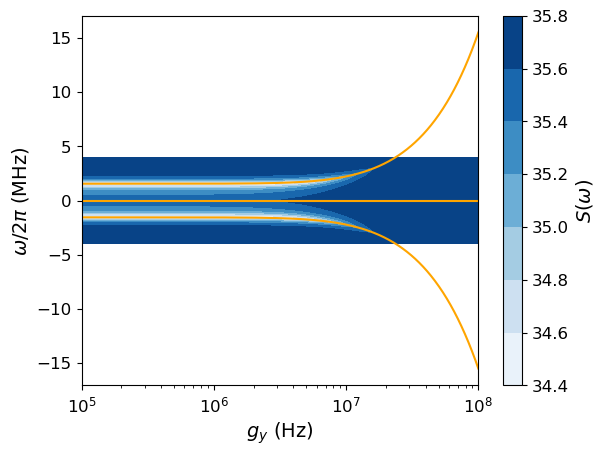

In [39]:
fig = plt.figure(1)
ax = fig.subplots(1, 1)
im = ax.contourf(gym, ωm / (2 * np.pi * 1e6), out_spec_gy_sweep, cmap='Blues')
ax.plot(gy, polariton_freqs_a / (2 * np.pi * 1e6), color='orange')
ax.plot(gy, polariton_freqs_b / (2 * np.pi * 1e6), color='orange')
ax.plot(gy, polariton_freqs_c / (2 * np.pi * 1e6), color='orange')
ax.set_xlabel("$g_y$ (Hz)")
ax.set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax.set_xscale('log')
fig.colorbar(im, label='$S(\\omega)$')

In [40]:
slice_gy_vals = [1e5, 1e6, 1e7]
out_spec_gy_sweep_slices = np.zeros((len(slice_gy_vals), ω.shape[0]))
for i in range(len(slice_gy_vals)):
    χ = slice_gy_vals[i]
    out_spec_gy_sweep_slices[i] = full_output_spec(ω, g, r, slice_gy_vals[i], χ, κ, γ, nT, nc, ny, Δ, Ω)

In [41]:
polariton_freqs_a = np.zeros(3, dtype=complex)
polariton_freqs_b = np.zeros(3, dtype=complex)
polariton_freqs_c = np.zeros(3, dtype=complex)
for i in range(len(slice_gy_vals)):
    temp = get_polariton_freq(κ, γ, 0, g, r, 0, slice_gy_vals[i], slice_gy_vals[i])
    print(temp / (2 * np.pi * 1e6))
    polariton_freqs_a[i] = temp[0]
    polariton_freqs_b[i] = temp[1]
    polariton_freqs_c[i] = temp[2]

[-1.54915233e+00 -5.31840171e-21  1.54915233e+00]
[-1.55644374e+00  1.71522784e-17  1.55644374e+00]
[-2.22096419  0.          2.22096419]


Text(0, 0.5, '$S(\\omega)$')

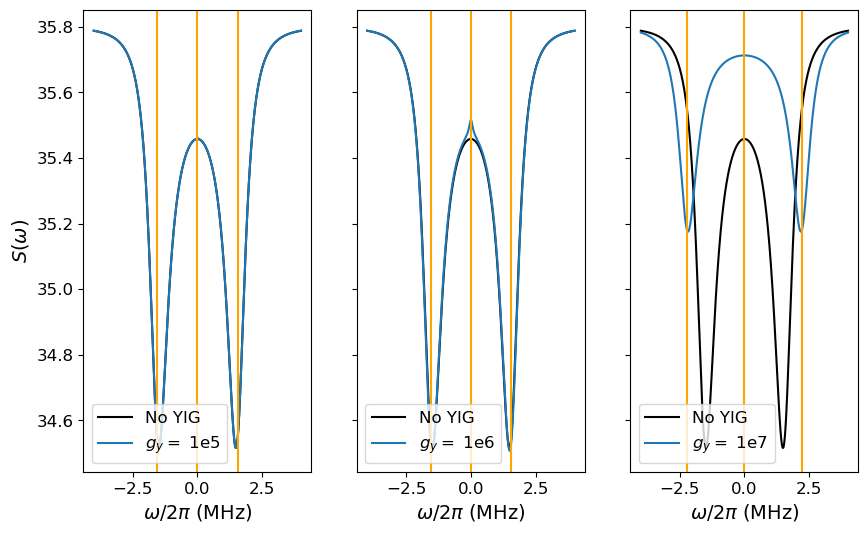

In [42]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
for i in range(len(slice_gy_vals)):
    ax[i].plot(ω / (2 * np.pi * 1e6), out_spec_no_yig, 'k-', label='No YIG')
    ax[i].plot(ω / (2 * np.pi * 1e6), out_spec_gy_sweep_slices[i], label='$g_y=$ 1e' + str(i+5))
    ax[i].axvline(x=polariton_freqs_a[i] / (2 * np.pi * 1e6), color='orange')
    ax[i].axvline(x=polariton_freqs_b[i] / (2 * np.pi * 1e6), color='orange')
    ax[i].axvline(x=polariton_freqs_c[i] / (2 * np.pi * 1e6), color='orange')
    ax[i].set_xlabel("$\\omega / 2\\pi$ (MHz)")
    ax[i].legend()
ax[0].set_ylabel("$S(\\omega)$")

#### $g$ sweep

In [43]:
# gy = 1e6 looked interesting, so I guess we'll set gy to that for now
gy = 1e6
χ = gy

In [44]:
g = np.logspace(5, 7, 1000)
ω = 2 * np.pi * np.linspace(-2, 2, 1000) * 1e6

# Set up meshgrid
gm, ωm = np.meshgrid(g, ω)

In [45]:
# YIG spectrum sweep over g
out_spec_g_sweep = full_output_spec(ωm, gm, gm, gy, χ, gm, γ, nT, nc, 0, Δ, Ω)

In [46]:
polariton_freqs_a = np.zeros(g.shape[0], dtype=complex)
polariton_freqs_b = np.zeros(g.shape[0], dtype=complex)
polariton_freqs_c = np.zeros(g.shape[0], dtype=complex)
for i in range(g.shape[0]):
    temp = get_polariton_freq(κ, γ, 0, g[i], g[i], 0, gy, gy)
    polariton_freqs_a[i] = temp[0]
    polariton_freqs_b[i] = temp[1]
    polariton_freqs_c[i] = temp[2]

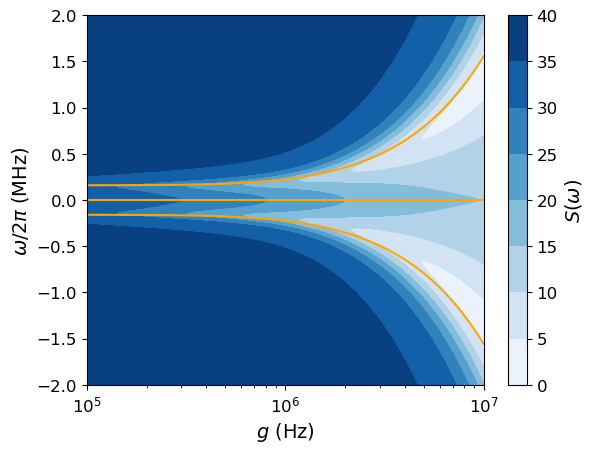

In [47]:
fig = plt.figure(1)
ax = fig.subplots(1, 1)
im = ax.contourf(gm, ωm / (2 * np.pi * 1e6), out_spec_g_sweep, cmap='Blues')
ax.plot(g, polariton_freqs_a / (2 * np.pi * 1e6), color='orange')
ax.plot(g, polariton_freqs_b / (2 * np.pi * 1e6), color='orange')
ax.plot(g, polariton_freqs_c / (2 * np.pi * 1e6), color='orange')
ax.set_xlabel("$g$ (Hz)")
ax.set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax.set_xscale('log')
fig.colorbar(im, label='$S(\\omega)$')

In [48]:
slice_g_vals = [1e5, 1e6, 1e7]
out_spec_g_sweep_slices = np.zeros((len(slice_g_vals), ω.shape[0]))
for i in range(len(slice_g_vals)):
    r = slice_g_vals[i]
    out_spec_g_sweep_slices[i] = full_output_spec(ω, slice_g_vals[i], r, gy, χ, slice_g_vals[i], γ, nT, nc, ny, Δ, Ω)

In [49]:
polariton_freqs_a = np.zeros(3, dtype=complex)
polariton_freqs_b = np.zeros(3, dtype=complex)
polariton_freqs_c = np.zeros(3, dtype=complex)
for i in range(len(slice_g_vals)):
    temp = get_polariton_freq(κ, γ, 0, slice_g_vals[i], slice_g_vals[i], 0, gy, gy)
    print(temp / (2 * np.pi * 1e6))
    polariton_freqs_a[i] = temp[0]
    polariton_freqs_b[i] = temp[1]
    polariton_freqs_c[i] = temp[2]

[-1.59667824e-01  1.80324234e-18  1.59667824e-01]
[-2.24966757e-01  9.26403696e-18  2.24966757e-01]
[-1.55644374e+00  1.71522784e-17  1.55644374e+00]


Text(0, 0.5, '$S(\\omega)$')

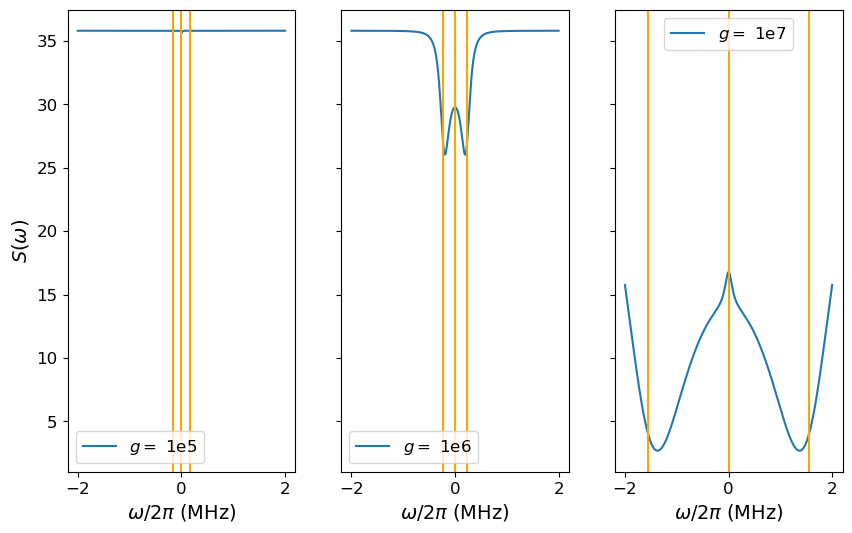

In [50]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
for i in range(len(slice_g_vals)):
    ax[i].plot(ω / (2 * np.pi * 1e6), out_spec_g_sweep_slices[i], label='$g=$ 1e' + str(i+5))
    ax[i].axvline(x=polariton_freqs_a[i] / (2 * np.pi * 1e6), color='orange')
    ax[i].axvline(x=polariton_freqs_b[i] / (2 * np.pi * 1e6), color='orange')
    ax[i].axvline(x=polariton_freqs_c[i] / (2 * np.pi * 1e6), color='orange')
    ax[i].set_xlabel("$\\omega / 2\\pi$ (MHz)")
    ax[i].legend()

ax[0].set_ylabel("$S(\\omega)$")

#### $\Delta$ sweep

In [51]:
# g = 1e7 looked interesting, so I guess we'll set gy to that for now
g = 1e7
r = g

In [52]:
Δ = np.logspace(4, 8, 1000)
Δn = -np.logspace(4, 8, 1000)
ω = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6

# Set up meshgrid
Δm, ωm = np.meshgrid(Δ, ω)
Δnm, ωm = np.meshgrid(Δn, ω)

In [53]:
out_spec_Δ_no_yig = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm, 0)
out_spec_Δn_no_yig = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δnm, 0)

# YIG spectrum sweep over Δ
out_spec_Δ_sweep = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δm, 0)
out_spec_Δn_sweep = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δnm, 0)

In [54]:
# Calculate polariton frequencies
no_yig_pol_freq_a = np.zeros(Δ.shape[0], dtype=complex)
no_yig_pol_freq_b = np.zeros(Δ.shape[0], dtype=complex)
yig_pol_freq_a = np.zeros(Δ.shape[0], dtype=complex)
yig_pol_freq_b = np.zeros(Δ.shape[0], dtype=complex)
yig_pol_freq_c = np.zeros(Δ.shape[0], dtype=complex)
for i in range(Δ.shape[0]):
    temp = get_nv_polariton_freq(κ, γ, Δ[i], g, r)
    no_yig_pol_freq_a[i] = temp[0]
    no_yig_pol_freq_b[i] = temp[1]

    temp = get_polariton_freq(κ, γ, Δ[i], g, r, 0, gy, gy)
    yig_pol_freq_a[i] = temp[0]
    yig_pol_freq_b[i] = temp[1]
    yig_pol_freq_c[i] = temp[2]

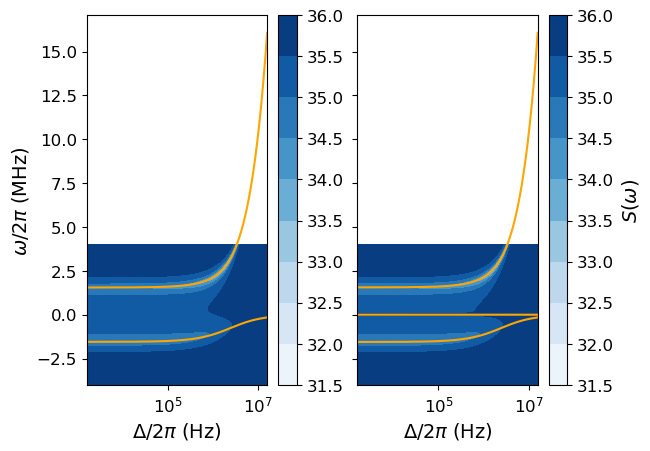

In [55]:
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharex='all', sharey='all')
im = ax[0].contourf(Δm / (2 * np.pi), ωm / (2 * np.pi * 1e6), out_spec_Δ_no_yig, cmap='Blues')#, norm=mpl.colors.LogNorm())
ax[0].plot(Δ / (2 * np.pi), no_yig_pol_freq_a / (2 * np.pi * 1e6), color='orange')
ax[0].plot(Δ / (2 * np.pi), no_yig_pol_freq_b / (2 * np.pi * 1e6), color='orange')
ax[0].set_xlabel("$\\Delta / 2\\pi$ (Hz)")
ax[0].set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_xscale('log')
fig.colorbar(im)

im2 = ax[1].contourf(Δm / (2 * np.pi), ωm / (2 * np.pi * 1e6), out_spec_Δ_sweep, cmap='Blues')#, norm=mpl.colors.LogNorm())
ax[1].plot(Δ / (2 * np.pi), yig_pol_freq_a / (2 * np.pi * 1e6), color='orange')
ax[1].plot(Δ / (2 * np.pi), yig_pol_freq_b / (2 * np.pi * 1e6), color='orange')
ax[1].plot(Δ / (2 * np.pi), yig_pol_freq_c / (2 * np.pi * 1e6), color='orange')
ax[1].set_xlabel("$\\Delta / 2\\pi$ (Hz)")
ax[1].set_xscale('log')
fig.colorbar(im2, label='$S(\\omega)$')

In [56]:
# Calculate polariton frequencies
no_yig_pol_freq_a = np.zeros(Δ.shape[0], dtype=complex)
no_yig_pol_freq_b = np.zeros(Δ.shape[0], dtype=complex)
yig_pol_freq_a = np.zeros(Δ.shape[0], dtype=complex)
yig_pol_freq_b = np.zeros(Δ.shape[0], dtype=complex)
yig_pol_freq_c = np.zeros(Δ.shape[0], dtype=complex)
for i in range(Δ.shape[0]):
    temp = get_nv_polariton_freq(κ, γ, Δn[i], g, r)
    no_yig_pol_freq_a[i] = temp[0]
    no_yig_pol_freq_b[i] = temp[1]

    temp = get_polariton_freq(κ, γ, Δn[i], g, r, 0, gy, gy)
    yig_pol_freq_a[i] = temp[0]
    yig_pol_freq_b[i] = temp[1]
    yig_pol_freq_c[i] = temp[2]

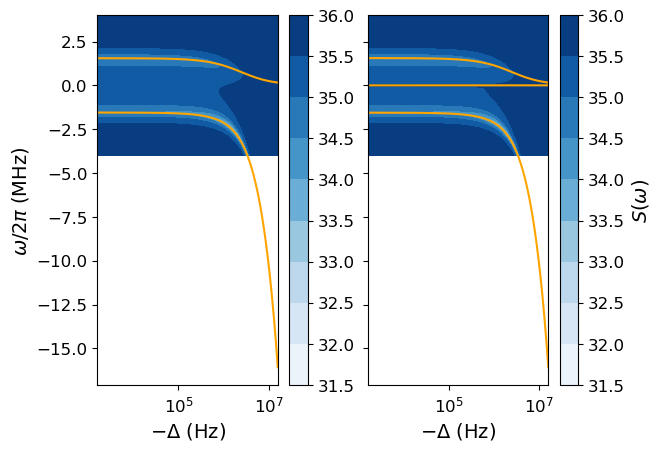

In [57]:
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharex='all', sharey='all')
im = ax[0].contourf(-Δnm / (2 * np.pi), ωm / (2 * np.pi * 1e6), out_spec_Δn_no_yig, cmap='Blues')#, norm=mpl.colors.LogNorm())
ax[0].plot(-Δn / (2 * np.pi), no_yig_pol_freq_a / (2 * np.pi * 1e6), color='orange')
ax[0].plot(-Δn / (2 * np.pi), no_yig_pol_freq_b / (2 * np.pi * 1e6), color='orange')
ax[0].set_xlabel("$-\\Delta$ (Hz)")
ax[0].set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_xscale('log')
fig.colorbar(im)

im2 = ax[1].contourf(-Δnm / (2 * np.pi), ωm / (2 * np.pi * 1e6), out_spec_Δn_sweep, cmap='Blues')#, norm=mpl.colors.LogNorm())
ax[1].plot(-Δn / (2 * np.pi), yig_pol_freq_a / (2 * np.pi * 1e6), color='orange')
ax[1].plot(-Δn / (2 * np.pi), yig_pol_freq_b / (2 * np.pi * 1e6), color='orange')
ax[1].plot(-Δn / (2 * np.pi), yig_pol_freq_c / (2 * np.pi * 1e6), color='orange')
ax[1].set_xlabel("$-\\Delta$ (Hz)")
ax[1].set_xscale('log')
fig.colorbar(im2, label='$S(\\omega)$')

In [58]:
slice_Δ_vals = [1e4, 1e5, 1e6, 1e7]
out_spec_Δ_sweep_slices = np.zeros((len(slice_Δ_vals), ω.shape[0]))
out_spec_Δ_no_yig_slices = np.zeros((len(slice_Δ_vals), ω.shape[0]))
out_spec_Δn_sweep_slices = np.zeros((len(slice_Δ_vals), ω.shape[0]))
out_spec_Δn_no_yig_slices = np.zeros((len(slice_Δ_vals), ω.shape[0]))
for i in range(len(slice_Δ_vals)):
    out_spec_Δ_sweep_slices[i] = full_output_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, slice_Δ_vals[i], 0)
    out_spec_Δ_no_yig_slices[i] = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, slice_Δ_vals[i], 0)
    out_spec_Δn_sweep_slices[i] = full_output_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, -slice_Δ_vals[i], 0)
    out_spec_Δn_no_yig_slices[i] = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, -slice_Δ_vals[i], 0)

In [59]:
no_yig_pol_freqs_a = np.zeros(len(slice_Δ_vals), dtype=complex)
no_yig_pol_freqs_b = np.zeros(len(slice_Δ_vals), dtype=complex)
for i in range(len(slice_Δ_vals)):
    temp = get_nv_polariton_freq(κ, γ, slice_Δ_vals[i], g, g)
    print(temp / (2 * np.pi * 1e6))
    no_yig_pol_freqs_a[i] = temp[0]
    no_yig_pol_freqs_b[i] = temp[1]

[-1.54828557  1.54987712]
[-1.54114496  1.55706046]
[-1.47165943  1.63081437]
[-0.95365581  2.54520525]


In [60]:
yig_pol_freqs_a = np.zeros(len(slice_Δ_vals), dtype=complex)
yig_pol_freqs_b = np.zeros(len(slice_Δ_vals), dtype=complex)
yig_pol_freqs_c = np.zeros(len(slice_Δ_vals), dtype=complex)
for i in range(len(slice_Δ_vals)):
    temp = get_polariton_freq(κ, γ, slice_Δ_vals[i], g, g, 0, gy, gy)
    print(temp / (2 * np.pi * 1e6))
    yig_pol_freqs_a[i] = temp[0]
    yig_pol_freqs_b[i] = temp[1]
    yig_pol_freqs_c[i] = temp[2]

[-1.55564659e+00 -3.17138738e-06  1.55724131e+00]
[-1.54849151e+00 -3.17132683e-05  1.56443872e+00]
[-1.47884420e+00 -3.16528380e-04  1.63831567e+00]
[-0.95820581 -0.00265634  2.55241158]


Text(0.5, 1.0, 'YIG')

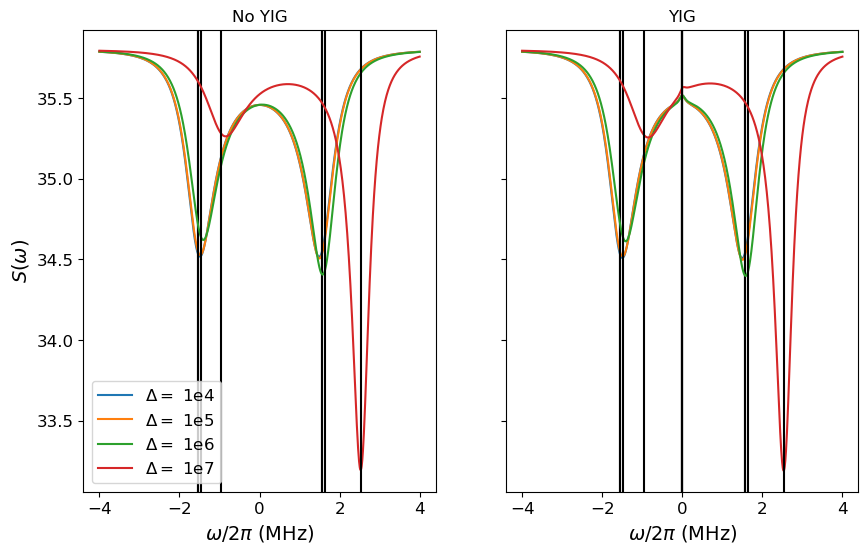

In [61]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 2, sharex='all', sharey='all')
for i in range(len(slice_Δ_vals)):
    ax[0].plot(ω / (2 * np.pi * 1e6), out_spec_Δ_no_yig_slices[i], label='$Δ=$ 1e' + str(i+4))
    ax[0].axvline(x=no_yig_pol_freqs_a[i] / (2 * np.pi * 1e6), color='black')
    ax[0].axvline(x=no_yig_pol_freqs_b[i] / (2 * np.pi * 1e6), color='black')
    
    ax[1].plot(ω / (2 * np.pi * 1e6), out_spec_Δ_sweep_slices[i], label='$Δ=$ 1e' + str(i+4))
    ax[1].axvline(x=yig_pol_freqs_a[i] / (2 * np.pi * 1e6), color='black')
    ax[1].axvline(x=yig_pol_freqs_b[i] / (2 * np.pi * 1e6), color='black')
    ax[1].axvline(x=yig_pol_freqs_c[i] / (2 * np.pi * 1e6), color='black')
ax[0].set_xlabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_ylabel("$S(\\omega)$")
#ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title("No YIG")

ax[1].set_xlabel("$\\omega / 2\\pi$ (MHz)")
#ax[1].set_yscale('log')
ax[1].set_title("YIG")

In [62]:
no_yig_pol_freqs_a = np.zeros(len(slice_Δ_vals), dtype=complex)
no_yig_pol_freqs_b = np.zeros(len(slice_Δ_vals), dtype=complex)
for i in range(len(slice_Δ_vals)):
    temp = get_nv_polariton_freq(κ, γ, -slice_Δ_vals[i], g, g)
    print(temp / (2 * np.pi * 1e6))
    no_yig_pol_freqs_a[i] = temp[0]
    no_yig_pol_freqs_b[i] = temp[1]

[-1.54987712  1.54828557]
[-1.55706046  1.54114496]
[-1.63081437  1.47165943]
[-2.54520525  0.95365581]


In [63]:
yig_pol_freqs_a = np.zeros(len(slice_Δ_vals), dtype=complex)
yig_pol_freqs_b = np.zeros(len(slice_Δ_vals), dtype=complex)
yig_pol_freqs_c = np.zeros(len(slice_Δ_vals), dtype=complex)
for i in range(len(slice_Δ_vals)):
    temp = get_polariton_freq(κ, γ, -slice_Δ_vals[i], g, g, 0, gy, gy)
    print(temp / (2 * np.pi * 1e6))
    yig_pol_freqs_a[i] = temp[0]
    yig_pol_freqs_b[i] = temp[1]
    yig_pol_freqs_c[i] = temp[2]

[-1.55724131e+00  3.17138738e-06  1.55564659e+00]
[-1.56443872e+00  3.17132683e-05  1.54849151e+00]
[-1.63831567e+00  3.16528380e-04  1.47884420e+00]
[-2.55241158  0.00265634  0.95820581]


Text(0.5, 1.0, 'YIG')

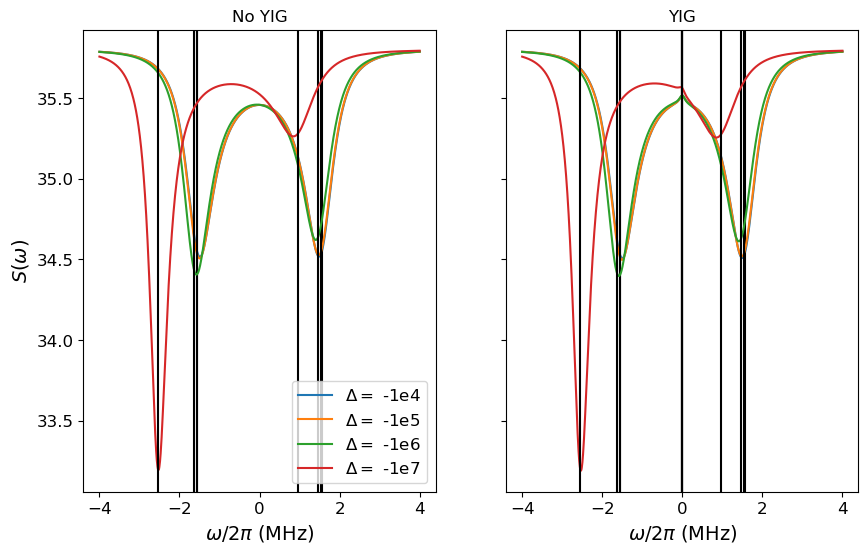

In [64]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 2, sharex='all', sharey='all')
for i in range(len(slice_Δ_vals)):
    ax[0].plot(ω / (2 * np.pi * 1e6), out_spec_Δn_no_yig_slices[i], label='$Δ=$ -1e' + str(i+4))
    ax[0].axvline(x=no_yig_pol_freqs_a[i] / (2 * np.pi * 1e6), color='black')
    ax[0].axvline(x=no_yig_pol_freqs_b[i] / (2 * np.pi * 1e6), color='black')
    
    ax[1].plot(ω / (2 * np.pi * 1e6), out_spec_Δn_sweep_slices[i], label='$Δ=$ -1e' + str(i+4))
    ax[1].axvline(x=yig_pol_freqs_a[i] / (2 * np.pi * 1e6), color='black')
    ax[1].axvline(x=yig_pol_freqs_b[i] / (2 * np.pi * 1e6), color='black')
    ax[1].axvline(x=yig_pol_freqs_c[i] / (2 * np.pi * 1e6), color='black')
ax[0].set_xlabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_ylabel("$S(\\omega)$")
#ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title("No YIG")

ax[1].set_xlabel("$\\omega / 2\\pi$ (MHz)")
#ax[1].set_yscale('log')
ax[1].set_title("YIG")

#### $\Omega$ sweep

In [65]:
Δ = 0

In [66]:
Ω = np.logspace(4, 8, 1000)
Ωn = - np.logspace(4, 8, 1000) 
ω = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6

# Set up meshgrid
Ωm, ωm = np.meshgrid(Ω, ω)
Ωnm, ωm = np.meshgrid(Ωn, ω)

In [67]:
out_spec_Ω_no_yig = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, Δ, 0)

# YIG spectrum sweep over Ω
out_spec_Ω_sweep = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, Ωm)
out_spec_Ωn_sweep = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, Ωnm)

In [68]:
# Calculate polariton frequencies
yig_pol_freq_a = np.zeros(Ω.shape[0], dtype=complex)
yig_pol_freq_b = np.zeros(Ω.shape[0], dtype=complex)
yig_pol_freq_c = np.zeros(Ω.shape[0], dtype=complex)
for i in range(Ω.shape[0]):
    temp = get_polariton_freq(κ, γ, Δ, g, r, Ω[i], gy, gy)
    yig_pol_freq_a[i] = temp[0]
    yig_pol_freq_b[i] = temp[1]
    yig_pol_freq_c[i] = temp[2]

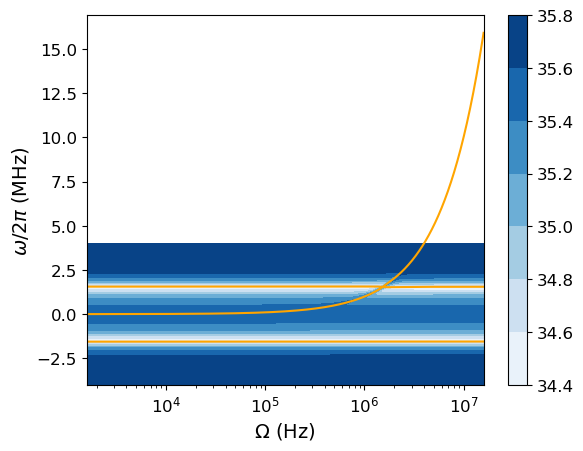

In [69]:
fig = plt.figure(1)
ax = fig.subplots(1)
im = ax.contourf(Ωm / (2 * np.pi), ωm / (2 * np.pi * 1e6), out_spec_Ω_sweep, cmap='Blues')#, norm=mpl.colors.LogNorm())
ax.plot(Ω / (2 * np.pi), yig_pol_freq_a / (2 * np.pi * 1e6), color='orange')
ax.plot(Ω / (2 * np.pi), yig_pol_freq_b / (2 * np.pi * 1e6), color='orange')
ax.plot(Ω / (2 * np.pi), yig_pol_freq_c / (2 * np.pi * 1e6), color='orange')
ax.set_xlabel("$\\Omega$ (Hz)")
ax.set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax.set_xscale('log')
fig.colorbar(im)

In [70]:
# Calculate polariton frequencies
yig_pol_freq_a = np.zeros(Ωn.shape[0], dtype=complex)
yig_pol_freq_b = np.zeros(Ωn.shape[0], dtype=complex)
yig_pol_freq_c = np.zeros(Ωn.shape[0], dtype=complex)
for i in range(Ωn.shape[0]):
    temp = get_polariton_freq(κ, γ, Δ, g, r, Ωn[i], gy, gy)
    yig_pol_freq_a[i] = temp[0]
    yig_pol_freq_b[i] = temp[1]
    yig_pol_freq_c[i] = temp[2]

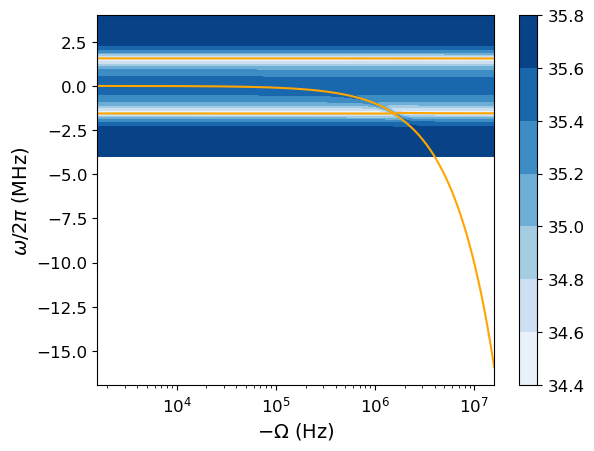

In [71]:
fig = plt.figure(1)
ax = fig.subplots(1)
im = ax.contourf(-Ωnm / (2 * np.pi), ωm / (2 * np.pi * 1e6), out_spec_Ωn_sweep, cmap='Blues')#, norm=mpl.colors.LogNorm())
ax.plot(-Ωn / (2 * np.pi), yig_pol_freq_a / (2 * np.pi * 1e6), color='orange')
ax.plot(-Ωn / (2 * np.pi), yig_pol_freq_b / (2 * np.pi * 1e6), color='orange')
ax.plot(-Ωn / (2 * np.pi), yig_pol_freq_c / (2 * np.pi * 1e6), color='orange')
ax.set_xlabel("$-\\Omega$ (Hz)")
ax.set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax.set_xscale('log')
fig.colorbar(im)

In [72]:
slice_Ω_vals = [1e4, 1e5, 1e6, 1e7]
out_spec_Ω_sweep_slices = np.zeros((len(slice_Ω_vals), ω.shape[0]))
out_spec_Ωn_sweep_slices = np.zeros((len(slice_Ω_vals), ω.shape[0]))
for i in range(len(slice_Ω_vals)):
    out_spec_Ω_sweep_slices[i] = full_output_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, slice_Ω_vals[i])
    out_spec_Ωn_sweep_slices[i] = full_output_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, -slice_Ω_vals[i])

In [73]:
yig_pol_freqs_a = np.zeros(len(slice_Ω_vals), dtype=complex)
yig_pol_freqs_b = np.zeros(len(slice_Ω_vals), dtype=complex)
yig_pol_freqs_c = np.zeros(len(slice_Ω_vals), dtype=complex)
for i in range(len(slice_Ω_vals)):
    temp = get_polariton_freq(κ, γ, Δ, g, g, slice_Ω_vals[i], gy, gy)
    print(temp / (2 * np.pi * 1e6))
    yig_pol_freqs_a[i] = temp[0]
    yig_pol_freqs_b[i] = temp[1]
    yig_pol_freqs_c[i] = temp[2]

[-1.55643734  0.00157874  1.55645015]
[-1.55638022  0.01578742  1.55650829]
[-1.55585144  0.15786689  1.55713949]
[-1.5529607   1.53201861  1.61249152]


Text(0, 0.5, '$S(\\omega)$')

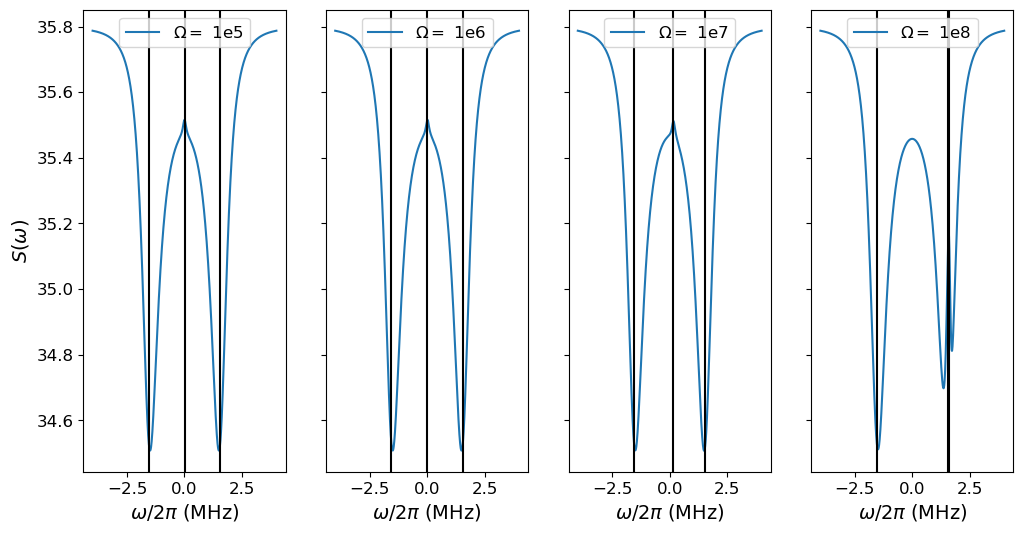

In [74]:
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(1, 4, sharex='all', sharey='all')
for i in range(len(slice_Ω_vals)):
    ax[i].plot(ω / (2 * np.pi * 1e6), out_spec_Ω_sweep_slices[i], label='$\\Omega=$ 1e' + str(i+5))
    ax[i].axvline(x=yig_pol_freqs_a[i] / (2 * np.pi * 1e6), color='black')
    ax[i].axvline(x=yig_pol_freqs_b[i] / (2 * np.pi * 1e6), color='black')
    ax[i].axvline(x=yig_pol_freqs_c[i] / (2 * np.pi * 1e6), color='black')
    ax[i].set_xlabel("$\\omega / 2\\pi$ (MHz)")
    ax[i].legend()
ax[0].set_ylabel("$S(\\omega)$")
#ax.set_yscale('log')

In [75]:
yig_pol_freqs_a = np.zeros(len(slice_Ω_vals), dtype=complex)
yig_pol_freqs_b = np.zeros(len(slice_Ω_vals), dtype=complex)
yig_pol_freqs_c = np.zeros(len(slice_Ω_vals), dtype=complex)
for i in range(len(slice_Ω_vals)):
    temp = get_polariton_freq(κ, γ, Δ, g, g, -slice_Ω_vals[i], gy, gy)
    print(temp / (2 * np.pi * 1e6))
    yig_pol_freqs_a[i] = temp[0]
    yig_pol_freqs_b[i] = temp[1]
    yig_pol_freqs_c[i] = temp[2]

[-1.55645015 -0.00157874  1.55643734]
[-1.55650829 -0.01578742  1.55638022]
[-1.55713949 -0.15786689  1.55585144]
[-1.61249152 -1.53201861  1.5529607 ]


Text(0, 0.5, '$S(\\omega)$')

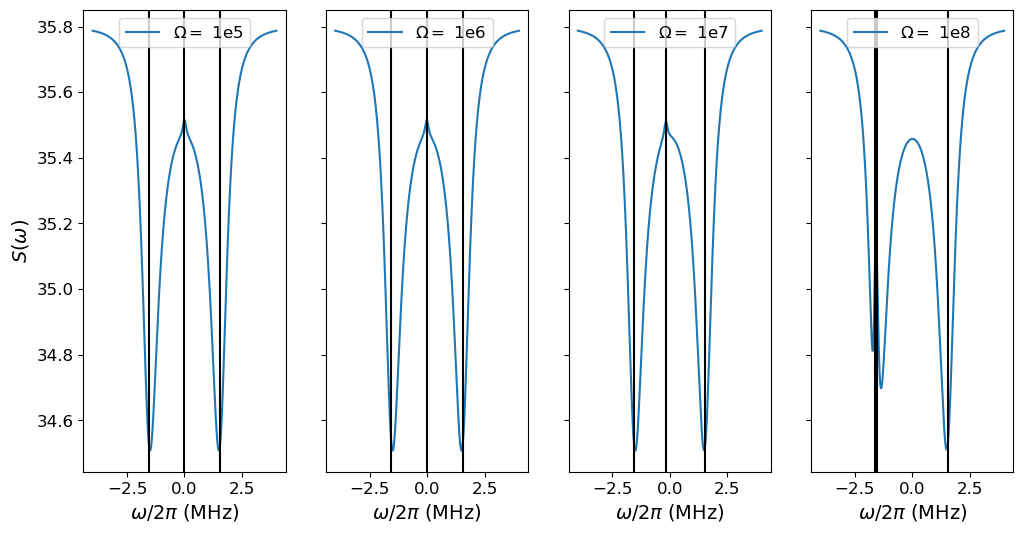

In [76]:
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(1, 4, sharex='all', sharey='all')
for i in range(len(slice_Ω_vals)):
    ax[i].plot(ω / (2 * np.pi * 1e6), out_spec_Ωn_sweep_slices[i], label='$\\Omega=$ 1e' + str(i+5))
    ax[i].axvline(x=yig_pol_freqs_a[i] / (2 * np.pi * 1e6), color='black')
    ax[i].axvline(x=yig_pol_freqs_b[i] / (2 * np.pi * 1e6), color='black')
    ax[i].axvline(x=yig_pol_freqs_c[i] / (2 * np.pi * 1e6), color='black')
    ax[i].set_xlabel("$\\omega / 2\\pi$ (MHz)")
    ax[i].legend()
ax[0].set_ylabel("$S(\\omega)$")

### Double-checking some things
It looks like increasing $g$ actually *increases* the temperature of the cavity mode when it should decrease the temperature.  We need to confirm if that is a genuine behavior or if there's a mistake somewhere.

In [77]:
# Experimental parameters for NV experiment
r = 2 * np.pi * 229e4
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 0
g = 2 * np.pi * 197.7e4
P = 0.8
nc = 0.5 * (1 - P) / P

Text(0, 0.5, '$S(\\omega)$')

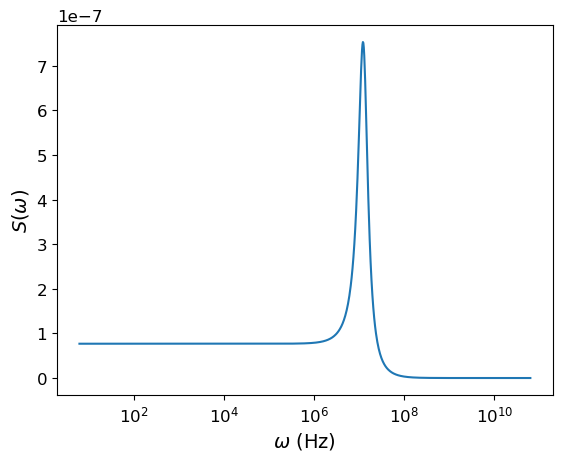

In [78]:
ω = 2 * np.pi * np.logspace(0, 10, 1000) # Hz
Δ = 0
expected_spectra = nv_cavity_spec(ω, g, r, κ, γ, nT, nc, Δ)

plt.figure(1)
plt.plot(ω, expected_spectra)
plt.xscale('log')
plt.xlabel("$\\omega$ (Hz)")
plt.ylabel("$S(\\omega)$")

In [79]:
expected_nbar = nv_mean_photons(κ, γ, g, r, nT, nc)
print("Number of photons: ", expected_nbar)
print("T: ", temp_from_photons(expected_nbar, ωc), ' K')

Number of photons:  2.8558680353970995
T:  0.3934013799522778  K
